<a href="https://colab.research.google.com/github/JSJeong-me/Detectron2/blob/main/colab_plant_segmentation_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation using Detectron2

## Using Detectron2 and mask R-CNN it is possible to isolate each leaf from the input image and extract the most prominent one for later analysis.

### Steps involved:

* Download and install detectron2 and other dependancies

* Hand annotate images with the objects mask (not covered in this kernel) - google "labelme" and "training detectron2 on custom dataset" 

* Train detectron2 (not covered in this kernel) 

* Load pretrained weights into detectron2

* Infer image masks and identifiy prominent objects

* Mask and extract from original image

* Crop and rotate object to fit

![Masked1](https://i.imgur.com/tnC1ljY.jpg "Masked Leaf 1")

![Masked](https://i.imgur.com/nemK62H.jpg "Masked Leaf")


### To Do:

* Futher training of the mask R-CNN model to improve segmentation.




# Imports

In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_list = []
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/KOSA/plant-pathology-2020-fgvc7.zip .

In [ ]:
!unzip ./plant-pathology-2020-fgvc7.zip

### Lets then download all of the required libraries to the kaggle kernel 

In [ ]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [18]:
import torch

In [ ]:
torch.__version__

In [ ]:
!nvcc --version

In [1]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

     |████████████████████████████████| 274 kB 4.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=cdb3d07ad92cd74a95c4b4d63766f25af9fb3b421842797a9d5d7bcb6112ef56
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu111 True


In [2]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 556 kB/s 
     |████████████████████████████████| 74 kB 2.1 MB/s 
     |████████████████████████████████| 130 kB 18.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 145 kB 50.6 MB/s 
     |████████████████████████████████| 743 kB 50.8 MB/s 
     |████████████████████████████████| 749 kB 31.4 MB/s 
     |████████████████████████████████| 112 kB 61.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=4ce83b720e561ccba433fca2542298304cbad985ea49b16b2fd8fdab68cb2517
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=868849253669fcf15f287f211552b98ae9a4093a604f9f387264e660dc63b4

### Import the required libraries.

In [1]:
import math  
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from PIL import Image
import cv2

## Detectron2 uses pytorch and makes it amazingly easy to retrain its pretrained model on a custom dataset. I won't go into the method of doing this but there is a wealth of information online. 

## The python tool "labelme" is great for drawing the masks over your images.

![labelme](https://i.imgur.com/phNlpnX.jpg "Label Me")




# Model Collection

### Below code is to download the pretrained weights from my google drive.

In [2]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [9]:
## download the pretrained weights for leaf segmentation.

file_id = '17AHanttKcR9B4A0m7QZqwAvaWxGrYYQp'
destination = './output/model.pth'
download_file_from_google_drive(file_id, destination)

In [10]:
#get the predictor
def get_predictor():


    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ()
    cfg.DATALOADER.NUM_WORKERS = 16

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (8)  # faster, and good enough for this toy dataset
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 3 classes (data, fig, hazelnut)

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "./model.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
    predictor = DefaultPredictor(cfg)
    return predictor

# Image manipulations

In [11]:
#function to get the leaf image.

def get_cropped_leaf(img,predictor,return_mapping=False,resize=None):
    #convert to numpy    
    img = np.array(img)[:,:,::-1]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    #get prediction
    outputs = predictor(img)
    
    #get boxes and masks
    ins = outputs["instances"]
    pred_masks = ins.get_fields()["pred_masks"]
    boxes = ins.get_fields()["pred_boxes"]    
    
    #get main leaf mask if the area is >= the mean area of boxes and is closes to the centre 
    
    masker = pred_masks[np.argmin([calculateDistance(x[0], x[1], int(img.shape[1]/2), int(img.shape[0]/2)) for i,x in enumerate(boxes.get_centers()) if (boxes[i].area()>=torch.mean(boxes.area()).to("cpu")).item()])].to("cpu").numpy().astype(np.uint8)

    #mask image
    mask_out = cv2.bitwise_and(img, img, mask=masker)
    
    #find contours and boxes
    contours, hierarchy = cv2.findContours(masker.copy() ,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[np.argmax([cv2.contourArea(x) for x in contours])]
    rotrect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rotrect)
    box = np.int0(box)
    

    #crop image
    cropped = get_cropped(rotrect,box,mask_out)

    #resize
    rotated = MakeLandscape()(Image.fromarray(cropped))
    
    if not resize == None:
        resized = ResizeMe((resize[0],resize[1]))(rotated)
    else:
        resized = rotated
        
    if return_mapping:
        img = cv2.drawContours(img, [box], 0, (0,0,255), 10)
        img = cv2.drawContours(img, contours, -1, (255,150,), 10)
        return resized, ResizeMe((int(resize[0]),int(resize[1])))(Image.fromarray(img))
    
    return resized

#function to crop the image to boxand rotate

def get_cropped(rotrect,box,image):
    
    width = int(rotrect[1][0])
    height = int(rotrect[1][1])

    src_pts = box.astype("float32")
    # corrdinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

def calculateDistance(x1,y1,x2,y2):  
    dist = math.hypot(x2 - x1, y2 - y1)
    return dist  


In [12]:
#image manipulations 

class ResizeMe(object):
    #resize and center image in desired size 
    def __init__(self,desired_size):
        
        self.desired_size = desired_size
        
    def __call__(self,img):
    
        img = np.array(img).astype(np.uint8)
        
        desired_ratio = self.desired_size[1] / self.desired_size[0]
        actual_ratio = img.shape[0] / img.shape[1]

        desired_ratio1 = self.desired_size[0] / self.desired_size[1]
        actual_ratio1 = img.shape[1] / img.shape[0]

        if desired_ratio < actual_ratio:
            img = cv2.resize(img,(int(self.desired_size[1]*actual_ratio1),self.desired_size[1]),None,interpolation=cv2.INTER_AREA)
        elif desired_ratio > actual_ratio:
            img = cv2.resize(img,(self.desired_size[0],int(self.desired_size[0]*actual_ratio)),None,interpolation=cv2.INTER_AREA)
        else:
            img = cv2.resize(img,(self.desired_size[0], self.desired_size[1]),None, interpolation=cv2.INTER_AREA)
            
        h, w, _ = img.shape

        new_img = np.zeros((self.desired_size[1],self.desired_size[0],3))
        
        hh, ww, _ = new_img.shape

        yoff = int((hh-h)/2)
        xoff = int((ww-w)/2)
        
        new_img[yoff:yoff+h, xoff:xoff+w,:] = img

        
        return Image.fromarray(new_img.astype(np.uint8))

class MakeLandscape():
    #flip if needed
    def __init__(self):
        pass
    def __call__(self,img):
        
        if img.height> img.width:
            img = np.rot90(np.array(img))
            img = Image.fromarray(img)
        return img


# Inference Method

### Load the predictor 

In [7]:
import os, json, cv2, random

In [13]:
predictor = get_predictor()

### Get Images

In [19]:
img, img1 = get_cropped_leaf(Image.open("./images/Train_1254.jpg"),predictor,return_mapping=True,resize = (512,int(512*.7)))

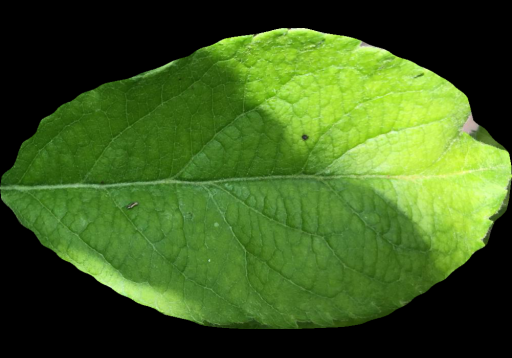

In [20]:
img

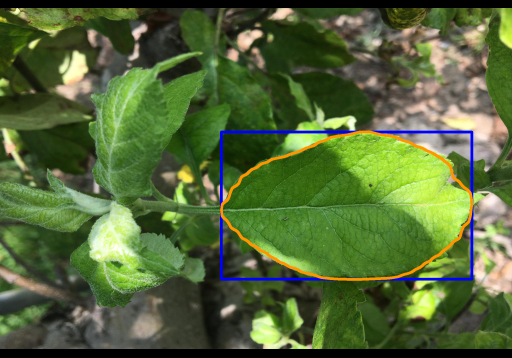

In [21]:
img1

# Display

### Display of multiple images stacked

In [24]:
final_image = []

for x in range(75):
    #select random image
    file_loc = file_list[np.random.randint(0,len(file_list))]
    #get outputs from predictor
    img, img1 = get_cropped_leaf(Image.open(file_loc),predictor,return_mapping=True,resize = (600,int(600*.65)))
    #stack horizontally
    stacked = np.hstack([img,img1])
    #append images
    final_image.append(stacked)


UnidentifiedImageError: ignored

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

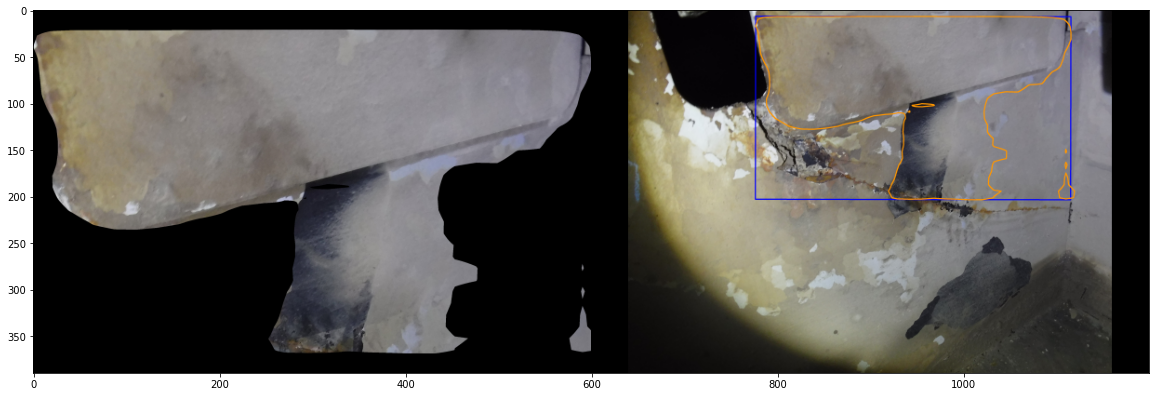

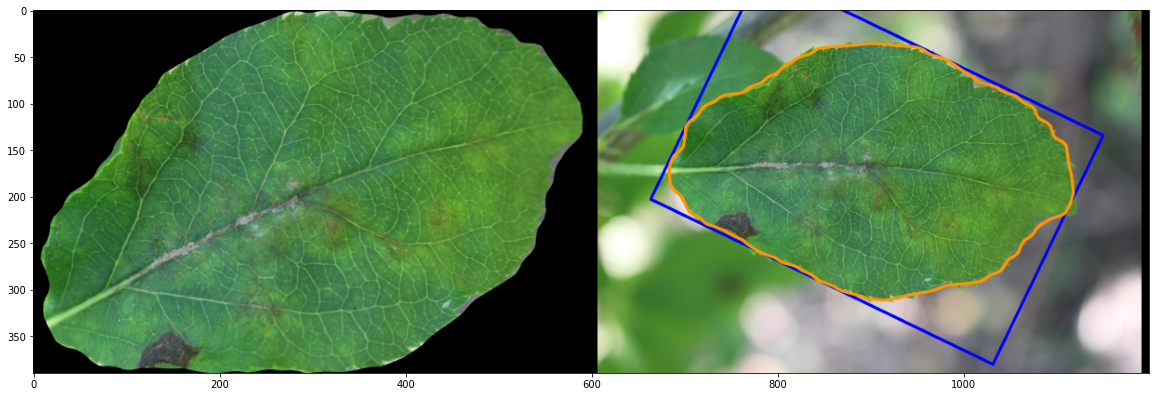

In [26]:
for x in final_image:
    fig = plt.figure(figsize=(20,10))
    plt.imshow(x)